# Human Pose Estimation using HRNet

In this notebook we illustrate how we can use our pipelines to evaluate in terms of human pose estimation (PE) the popular method HRNet [1], which achieves state-of-the-art in common benchmark datasets.

We show how to use the data loaders to sample images and the corresponding annotations from the COCO [2] validation set and how to use a pretrained model to extract keypoints and pose from the image. Finally, we also report how to compute the loss value and the COCO evaluation metrics (precision and recall).

In [1]:
import os
import sys

import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

sys.path.append("..")

import models
import data

import data.data_processing as data_processing
import lib.utils as utils
import lib.visualizations as visualizations
import lib.pose_parsing as pose_parsing
import lib.metrics as metrics
from data.custom_transforms import Normalize
from lib.loss import PersonMSELoss
from CONFIG import CONFIG
import CONSTANTS

In [6]:
exp_name = os.path.join("detector_tests", "hrnet_notebook")
test_exp = os.path.join(CONFIG["paths"]["experiments_path"], exp_name)
data_path = CONFIG["paths"]["data_path"]
original_imgs_path = os.path.join(data_path, "original_images", "val2017")
labels_path = os.path.join(data_path, "annotations")
labels_file = os.path.join(labels_path, "person_keypoints_validation.json")
preds_file = os.path.join(test_exp, CONFIG["paths"]["submission"])

In [7]:
pose_parsing.SKELETON = CONSTANTS.SKELETON_HRNET
data_processing.TO_COCO_MAP = CONSTANTS.COCO_MAP_HRNET
data_processing.SKIP_NECK = False

In [8]:
%reload_ext autoreload
%autoreload 2

# Dataset

For this introductory notebook, we will sample some random image from the COCO validation set [2].

In [9]:
exp_data = utils.load_experiment_parameters(test_exp)

In [10]:
# initializing a random data loader iterator to sample images from the 
# COCO validation set
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
normalize = transforms.Normalize(
    mean=mean.tolist(), std=std.tolist()
)

In [11]:
hrnet_dataset = data.HRNetCoco(exp_data=exp_data, root=data_path, img_path=original_imgs_path,
                               labels_path=labels_file, is_train=False,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   normalize,
                               ]))

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


In [12]:
image_idx = np.random.randint(low=0, high=len(hrnet_dataset))
image_name = hrnet_dataset.get_name_given_id(image_idx)
print(f"ID: {image_idx}  --  Image: {image_name}")

ID: 4641  --  Image: 000000065455.jpg


In [13]:
# sampling a person-crop and the annotatios  
imgs, target, target_weight, metadata = hrnet_dataset.get_all_samples_given_name(image_name)
n_humans = imgs.shape[0]
print(f"N People: {n_humans}")
full_img_path = metadata["image"][0]
full_img = cv2.imread(full_img_path, cv2.IMREAD_COLOR)
full_img = cv2.cvtColor(full_img, cv2.COLOR_RGB2BGR)

N People: 5


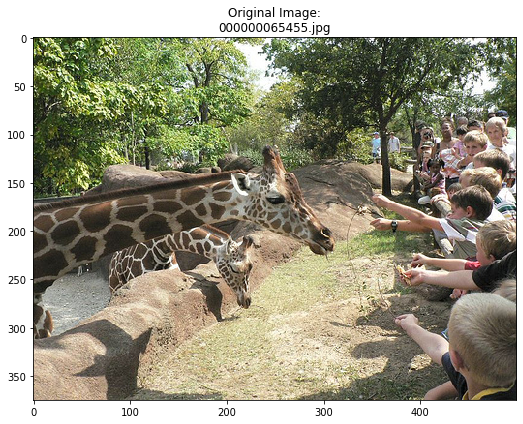

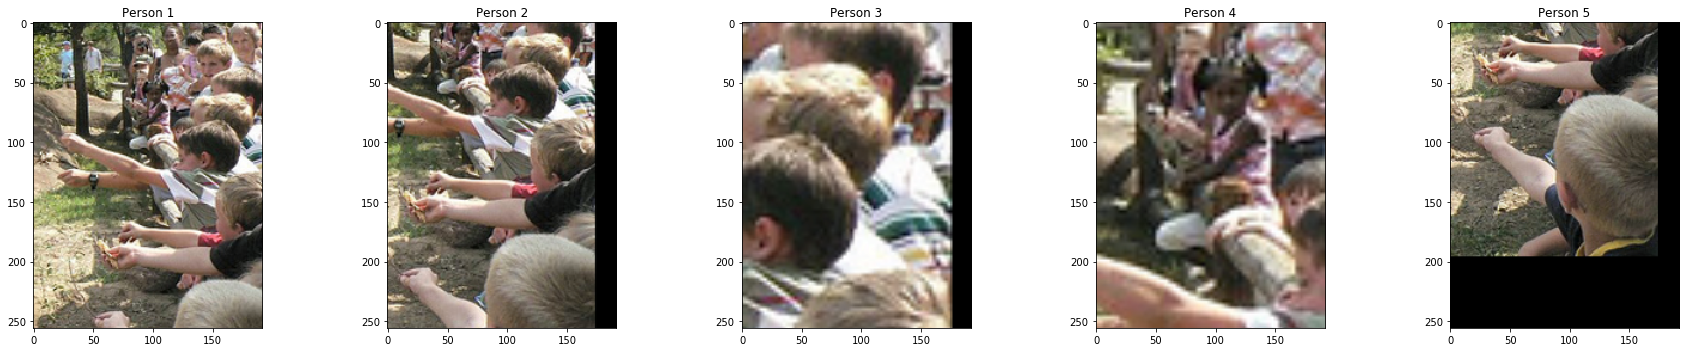

In [16]:
img_path = metadata["image"][0]
full_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
full_img = cv2.cvtColor(full_img, cv2.COLOR_RGB2BGR)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)
ax.imshow(full_img)
ax.set_title(f"Original Image:\n{img_path.split('/')[-1]}")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,n_humans)
fig.set_size_inches(5*n_humans, 5)
for i in range(n_humans):
    if(n_humans == 1):
        visualizations.visualize_image(np.array(imgs[i,:]), ax=ax, 
                                       title=f"Person {i+1}", preprocess=True)
    else:
        visualizations.visualize_image(np.array(imgs[i,:]), ax=ax[i],
                                       title=f"Person {i+1}", preprocess=True)
plt.tight_layout()
plt.show()


# Models

In order to estimate the keypoint locations and to estimate the pose, we load an HRNet model that has already been trained on the COCO training set. The authors report that this model achieves a  Mean Average Precision (mAP) of 0.72 for the COCO Validation set.

In [17]:
# HRNet Model
hrnet = models.PoseHighResolutionNet(is_train=False)
pretrained_path = os.path.join(CONFIG["paths"]["pretrained_path"], "HRnet", "pose_hrnet_w32_256x192.pth")
hrnet.load_state_dict(torch.load(pretrained_path))

<All keys matched successfully>

In [18]:
# we set the model to use the GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"  # for just one image we can simply use 'cpu'
hrnet = hrnet.to(device)
hrnet = hrnet.eval()

# defining loss function
loss_function = PersonMSELoss()

# Inference

We now use the model to estimate the keypoints, predict the human pose and compute the loss and evaluation metrics

In [19]:
output = hrnet(imgs.float())
scaled_output = F.interpolate(output.clone().detach(), (256, 192),
                              mode="bilinear", align_corners=True)
n_images = output.shape[0]
n_joints = output.shape[1]

In [20]:
loss_value = loss_function(output, target, target_weight).item()
print(f"Loss Value: {round(loss_value,5)}")

Loss Value: 0.00024


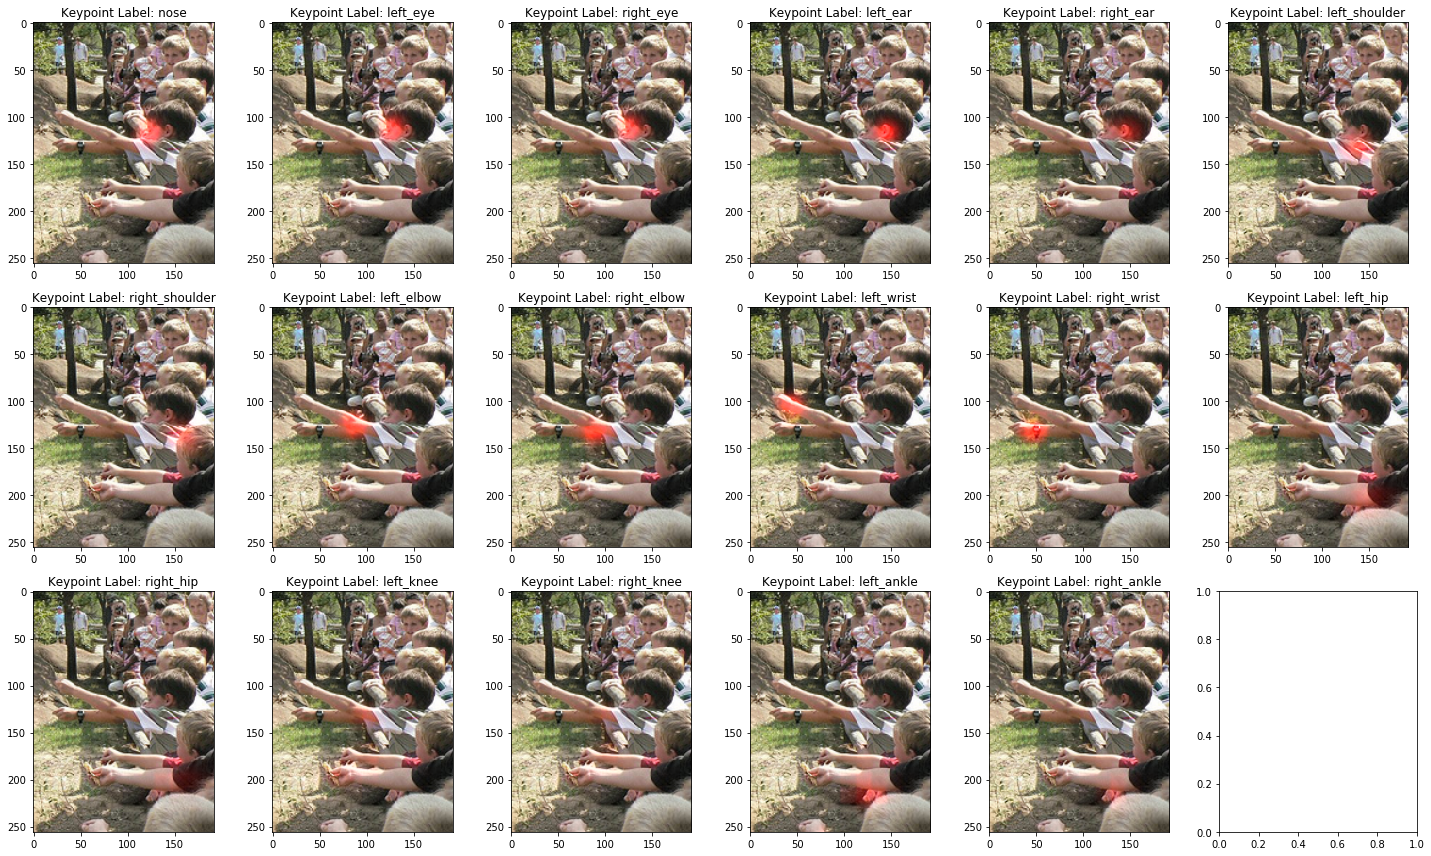

In [21]:
fig, ax = plt.subplots(3,6)
fig.set_size_inches(20,12)

for i in range(n_joints):
    row = i // 6
    col = i% 6
    title = f"Keypoint Label: {CONSTANTS.IDX_TO_KPT_NAME[i]}"
    visualizations.overlay_heatmap(heatmap=np.array(scaled_output[0,i,:].cpu()), img=np.array(imgs[0,:].cpu()),
                                   ax=ax[row, col], title=title)
plt.tight_layout()
plt.show()

In [ ]:
# pose parsing
centers = metadata["center"].numpy()
scales = metadata["scale"].numpy()
score = metadata["score"].numpy()

keypoints, max_vals, coords = pose_parsing.get_final_preds_hrnet(output.cpu().detach().numpy(), centers, scales)
pose_entries, all_keypoints = pose_parsing.create_pose_entries(keypoints)

all_keypoints = [all_keypoints[:, 1], all_keypoints[:, 0], all_keypoints[:, 2], all_keypoints[:, 3]]
all_keypoints = np.array(all_keypoints).T


fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)

title = "Pose from Detections"
visualizations.draw_pose(full_img, pose_entries, all_keypoints, ax=ax, title=title)

# Computing COCO Evaluation Metrics

In [ ]:
all_preds = np.zeros((n_humans, 17, 3), dtype=np.float32)
all_preds[:,:,:2] = keypoints[:,:,:2]
all_preds[:,:,2:3] = max_vals

In [ ]:
all_boxes = np.zeros((n_humans, 6))
all_boxes[:, 0:2] = centers[:, 0:2]
all_boxes[:, 2:4] = scales[:, 0:2]
all_boxes[:, 4] = np.prod(scales*200, 1)
all_boxes[:, 5] = score

In [ ]:
utils.reset_predictions_file(test_exp)
metrics.generate_submission_hrnet(all_preds=[all_preds], all_bboxes=[all_boxes], 
                                  image_names=[img_path]*n_humans, preds_file=preds_file)

In [24]:
stats = metrics.compute_precision(labels_file=labels_file, preds_file=preds_file)

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.856
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.911
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.843
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.858
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.917
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | ma

# References

**[1]** Sun, Ke, et al. *Deep high-resolution representation learning for human pose estimation.* Proceedings of the IEEE conference on computer vision and pattern recognition. 2019.

**[2]** Lin, Tsung-Yi, et al. *Microsoft coco: Common objects in context.* European conference on computer vision. Springer, Cham, 2014.

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
   This notebook was created by <b>Angel Villar-Corrales</b>
</div> 